# Task#1

## Installing PySpark


In [ ]:
pip install pyspark

## Importing Libraries

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql.functions import col

In [ ]:
spark = SparkSession.builder.appName("RecommenderSystem").getOrCreate()

## Load and Preprocess Data

In [ ]:
movies_df = spark.read.csv('movies.csv',header=True,inferSchema=True)
movies_df.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [ ]:
ratings_df = spark.read.csv('ratings.csv',header=True,inferSchema=True)
ratings_df.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
|     1|   1088|   4.0|1147868495|
|     1|   1175|   3.5|1147868826|
|     1|   1217|   3.5|1147878326|
|     1|   1237|   5.0|1147868839|
|     1|   1250|   4.0|1147868414|
|     1|   1260|   3.5|1147877857|
|     1|   1653|   4.0|1147868097|
|     1|   2011|   2.5|1147868079|
|     1|   2012|   2.5|1147868068|
|     1|   2068|   2.5|1147869044|
|     1|   2161|   3.5|1147868609|
|     1|   2351|   4.5|1147877957|
|     1|   2573|   4.0|1147878923|
|     1|   2632|   5.0|1147878248|
|     1|   2692|   5.0|1147869100|
+------+-------+------+----------+
only showing top 20 rows



## Combining Movies&Ratings

In [ ]:
Combined_df = ratings_df.join(movies_df, "movieId","inner")
Combined_df.show()

+-------+------+------+----------+--------------------+--------------------+
|movieId|userId|rating| timestamp|               title|              genres|
+-------+------+------+----------+--------------------+--------------------+
|    296|     1|   5.0|1147880044| Pulp Fiction (1994)|Comedy|Crime|Dram...|
|    306|     1|   3.5|1147868817|Three Colors: Red...|               Drama|
|    307|     1|   5.0|1147868828|Three Colors: Blu...|               Drama|
|    665|     1|   5.0|1147878820|  Underground (1995)|    Comedy|Drama|War|
|    899|     1|   3.5|1147868510|Singin' in the Ra...|Comedy|Musical|Ro...|
|   1088|     1|   4.0|1147868495|Dirty Dancing (1987)|Drama|Musical|Rom...|
|   1175|     1|   3.5|1147868826| Delicatessen (1991)|Comedy|Drama|Romance|
|   1217|     1|   3.5|1147878326|          Ran (1985)|           Drama|War|
|   1237|     1|   5.0|1147868839|Seventh Seal, The...|               Drama|
|   1250|     1|   4.0|1147868414|Bridge on the Riv...| Adventure|Drama|War|

## Droping Ireralvant Columns

In [ ]:
Combined_data = Combined_df.drop('timestamp', 'genres')
Combined_data.show()

+-------+------+------+--------------------+
|movieId|userId|rating|               title|
+-------+------+------+--------------------+
|    296|     1|   5.0| Pulp Fiction (1994)|
|    306|     1|   3.5|Three Colors: Red...|
|    307|     1|   5.0|Three Colors: Blu...|
|    665|     1|   5.0|  Underground (1995)|
|    899|     1|   3.5|Singin' in the Ra...|
|   1088|     1|   4.0|Dirty Dancing (1987)|
|   1175|     1|   3.5| Delicatessen (1991)|
|   1217|     1|   3.5|          Ran (1985)|
|   1237|     1|   5.0|Seventh Seal, The...|
|   1250|     1|   4.0|Bridge on the Riv...|
|   1260|     1|   3.5|            M (1931)|
|   1653|     1|   4.0|      Gattaca (1997)|
|   2011|     1|   2.5|Back to the Futur...|
|   2012|     1|   2.5|Back to the Futur...|
|   2068|     1|   2.5|Fanny and Alexand...|
|   2161|     1|   3.5|NeverEnding Story...|
|   2351|     1|   4.5|Nights of Cabiria...|
|   2573|     1|   4.0|        Tango (1998)|
|   2632|     1|   5.0|Saragossa Manuscr...|
|   2692| 

In [ ]:
# Split the data into training and testing sets
(training, test) = Combined_data.randomSplit([0.8, 0.2])

## Biulding Model

In [ ]:
# Build the ALS model
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating")
model = als.fit(training)

In [ ]:
predictions = model.transform(test)

## Evaluate the model using RMSE (Root Mean Squared Error)

In [ ]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): nan


## Results

In [ ]:
# Generate top N movie recommendations for each user
userRecs = model.recommendForAllUsers(5)
userRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     1|[{151410, 15.8923...|
|     3|[{151410, 14.7058...|
|     5|[{151410, 15.8792...|
|     6|[{151410, 17.2849...|
|     9|[{141546, 17.4446...|
|    12|[{151410, 15.1439...|
|    13|[{151410, 16.0737...|
|    15|[{151410, 16.2296...|
|    16|[{151410, 17.0141...|
|    17|[{194232, 14.5398...|
|    19|[{151410, 14.3613...|
|    20|[{151410, 16.3356...|
|    22|[{141546, 20.9663...|
|    26|[{151410, 12.7887...|
|    27|[{134499, 18.4799...|
|    28|[{151410, 17.6476...|
|    31|[{151410, 10.3232...|
|    34|[{151410, 12.8452...|
|    35|[{151410, 15.2325...|
|    37|[{151410, 15.2431...|
+------+--------------------+
only showing top 20 rows



In [ ]:
# Generate top N user recommendations for each movie
movieRecs = model.recommendForAllItems(10)  # You can customize the number of recommendations (e.g., 10)
movieRecs.show()


+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|      1|[{58248, 6.731963...|
|      3|[{63627, 6.497902...|
|      5|[{48142, 5.216825...|
|      6|[{35967, 6.296840...|
|      9|[{54272, 5.407299...|
|     12|[{32039, 6.814162...|
|     13|[{44706, 6.572505...|
|     15|[{70377, 6.668667...|
|     16|[{66514, 5.610940...|
|     17|[{58248, 6.853069...|
|     19|[{48142, 7.879942...|
|     20|[{11711, 5.678684...|
|     22|[{29128, 5.983080...|
|     26|[{67918, 6.117408...|
|     27|[{66461, 7.263832...|
|     28|[{47404, 7.094831...|
|     31|[{27163, 5.564129...|
|     34|[{58248, 7.657267...|
|     35|[{27666, 7.617774...|
|     37|[{71086, 9.581475...|
+-------+--------------------+
only showing top 20 rows



In [ ]:
# Close the Spark session
spark.stop()

# Task#2

## Importing Libraries



In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.sql.types import StringType
from pyspark.ml.clustering import KMeans
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import PCA
from pyspark.ml.regression import IsotonicRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [ ]:
spark = SparkSession.builder.appName("Heart_diseases_detection").getOrCreate()

## Load and Preprocess Data

In [ ]:
heart_df = spark.read.csv('heart.csv',header=True,inferSchema=True)
heart_df.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|    0.0|      Up|           0|
| 39|  M|          NAP|      120|        339|        0| 

In [ ]:
# Display the schema of the dataset
heart_df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- ChestPainType: string (nullable = true)
 |-- RestingBP: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- FastingBS: integer (nullable = true)
 |-- RestingECG: string (nullable = true)
 |-- MaxHR: integer (nullable = true)
 |-- ExerciseAngina: string (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: string (nullable = true)
 |-- HeartDisease: integer (nullable = true)



In [ ]:
# Get the number of rows and columns in the DataFrame
rows = heart_df.count()
cols = len(heart_df.columns)
print(f"There are {rows} rows and {cols} columns in the dataset")


There are 918 rows and 12 columns in the dataset


In [ ]:
duplicated_count = heart_df.groupBy(heart_df.columns).count().filter(col("count") > 1).count()

print(f"There are {duplicated_count} columns in the dataset with duplicates.")

There are 0 columns in the dataset with duplicates.


## Getting Categorical&Numerical Columns

In [ ]:
catcol = []
numcol = []

# Iterate through the columns of the DataFrame
for col_name in heart_df.columns:
    # Check the data type of the column
    if isinstance(heart_df.schema[col_name].dataType, StringType):
        # If the data type is StringType, add it to the categorical column list
        catcol.append(col_name)
    else:
        # Otherwise, add it to the numerical column list
        numcol.append(col_name)

# Display the categorical and numerical columns
print("Categorical Columns:", catcol)
print("Numerical Columns:", numcol)


Categorical Columns: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Numerical Columns: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']


## Converting Categoricla to Numerical

In [ ]:
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(heart_df) for column in ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]]
pipeline = Pipeline(stages=indexers)
data = pipeline.fit(heart_df).transform(heart_df)


## Feature Extraction

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer

# Apply StringIndexer to DataFrame
indexed_data = heart_df
for indexer in indexers:
    indexed_data = indexer.transform(indexed_data)

# Create a feature vector
feature_columns = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak", "Sex_index", "ChestPainType_index", "RestingECG_index", "ExerciseAngina_index", "ST_Slope_index"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(indexed_data)

## Spliting Dataset into training & testing

In [ ]:
(trainingData, testData) = data.randomSplit([0.8, 0.2])

## Model Training

## Using Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(labelCol="HeartDisease", featuresCol="features", numTrees=10)
model = rf.fit(trainingData)

In [ ]:
# Make predictions on the test set
predictions = model.transform(testData)

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print(f"Area under ROC curve: {accuracy}")

Area under ROC curve: 0.9204912734324499


## K-Means Clustering

In [ ]:
kmeans = KMeans(k=2, seed=42, featuresCol='features', predictionCol='kmeans_prediction')
kmeans_model = kmeans.fit(trainingData)
kmeans_predictions = kmeans_model.transform(trainingData)

## Linear Regression

In [ ]:
lr_reg = LinearRegression(labelCol='HeartDisease', featuresCol='features')
lr_model_reg = lr_reg.fit(trainingData)
lr_predictions_reg = lr_model_reg.transform(testData)

## Support Vector Classifier

In [ ]:
svc = LinearSVC(labelCol='HeartDisease', featuresCol='features')
svc_model = svc.fit(trainingData)
svc_predictions = svc_model.transform(testData)


## Decision Tree Classification

In [ ]:
dt = DecisionTreeClassifier(labelCol='HeartDisease', featuresCol='features')
dt_model = dt.fit(trainingData)
dt_predictions = dt_model.transform(testData)

## Gradient Boosting

In [ ]:
gbt_reg = GBTRegressor(labelCol='HeartDisease', featuresCol='features')
gbt_model_reg = gbt_reg.fit(trainingData)
gbt_predictions_reg = gbt_model_reg.transform(testData)

## Logistic Regression

In [ ]:
lr_classifier = LogisticRegression(labelCol='HeartDisease', featuresCol='features')
lr_model_classifier = lr_classifier.fit(trainingData)
lr_predictions_classifier = lr_model_classifier.transform(testData)


## Principal Component Analysis (PCA)

In [ ]:
pca = PCA(k=5, inputCol='features', outputCol='pca_features')
pca_model = pca.fit(trainingData)
data_pca = pca_model.transform(testData)

## Isotonic Regression

In [ ]:
iso_reg = IsotonicRegression(labelCol='HeartDisease', featuresCol='features')
iso_model = iso_reg.fit(trainingData)
iso_predictions = iso_model.transform(testData)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Assuming 'labelCol' is the actual label column in your data
iso_evaluator = RegressionEvaluator(labelCol='HeartDisease', metricName='mse')
iso_mse = iso_evaluator.evaluate(iso_predictions)

## Model evaluation for regression models

In [ ]:
evaluator_reg = RegressionEvaluator(labelCol='HeartDisease', metricName='rmse')

lr_rmse = evaluator_reg.evaluate(lr_predictions_reg)
gbt_rmse = evaluator_reg.evaluate(gbt_predictions_reg)

## Visualize the results

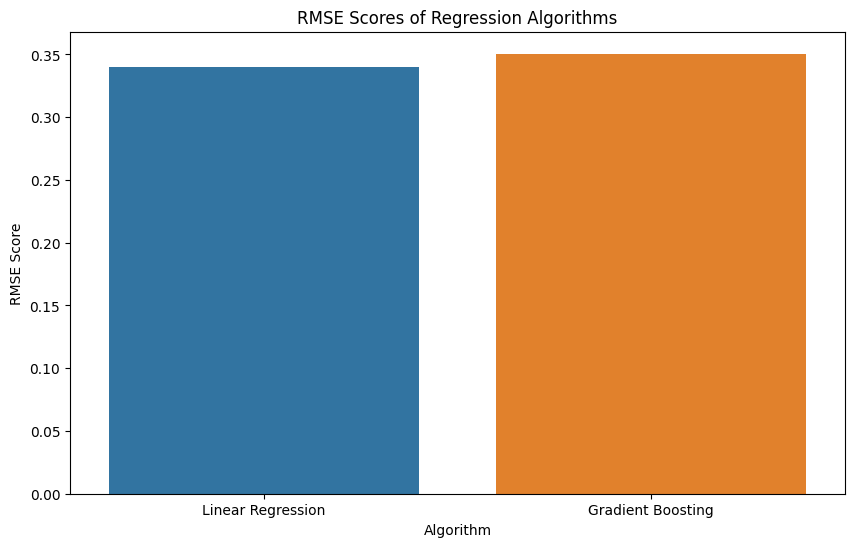

In [ ]:
algorithm_names_reg = ['Linear Regression',  'Gradient Boosting']
rmse_scores = [lr_rmse, gbt_rmse]

plt.figure(figsize=(10, 6))
sns.barplot(x=algorithm_names_reg, y=rmse_scores)
plt.title('RMSE Scores of Regression Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('RMSE Score')
plt.show()

## Model evaluation for classification models

In [ ]:
evaluator_classifier = BinaryClassificationEvaluator(labelCol='HeartDisease')

svc_auc = evaluator_classifier.evaluate(svc_predictions)
dt_auc = evaluator_classifier.evaluate(dt_predictions)
lr_auc_classifier = evaluator_classifier.evaluate(lr_predictions_classifier)
iso_mse = iso_evaluator.evaluate(iso_predictions)

## Visualize the results

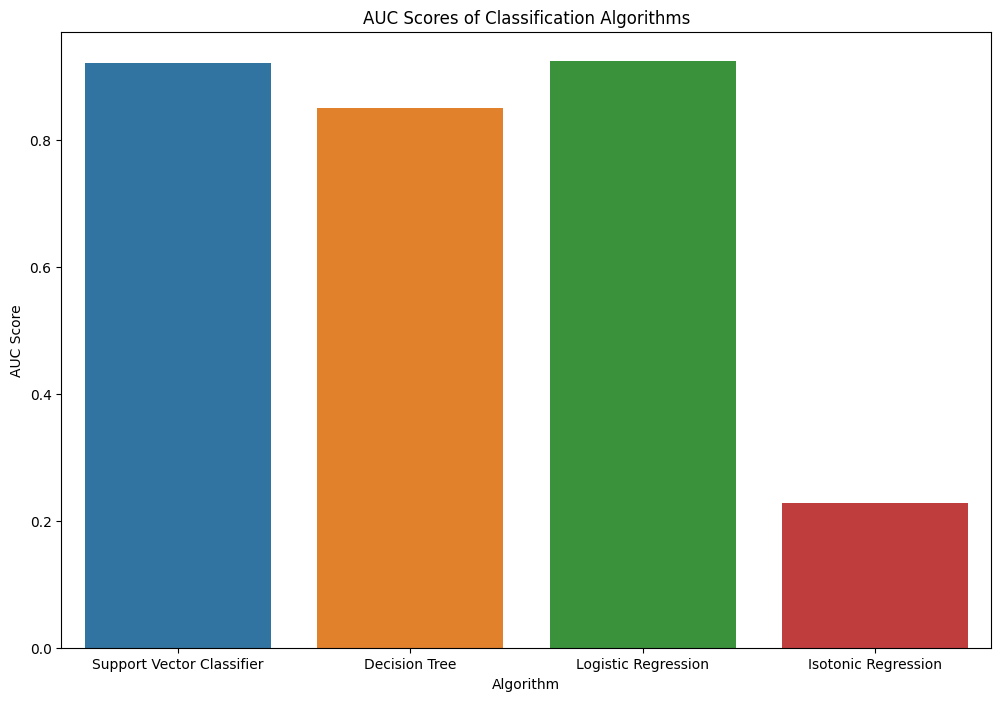

In [ ]:
algorithm_names_classifier = [ 'Support Vector Classifier', 'Decision Tree', 'Logistic Regression','Isotonic Regression']
auc_scores_classifier = [ svc_auc, dt_auc, lr_auc_classifier, iso_mse]

plt.figure(figsize=(12, 8))
sns.barplot(x=algorithm_names_classifier, y=auc_scores_classifier)
plt.title('AUC Scores of Classification Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('AUC Score')
plt.show()

## Visualization Results

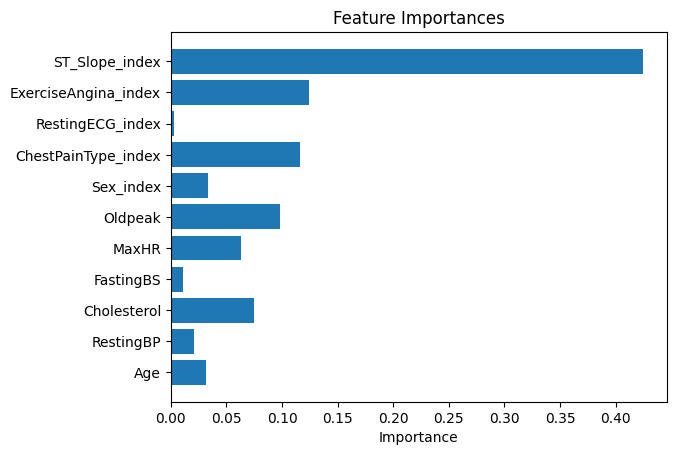

In [ ]:
# Visualize feature importances
feature_importances = model.featureImportances.toArray()
feature_names = feature_columns
y_pos = range(len(feature_names))

plt.barh(y_pos, feature_importances, align='center')
plt.yticks(y_pos, feature_names)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

In [ ]:
# Stop the Spark session
spark.stop()